# Gaps Detection

## Gaps on audio
Gaps are generally produced by hardware or software issues in the process of recording or copying audio data.
They can be distinguished from discontinuities because instead of missing some audio timestamps, the degraded segment is overwritten with zeros or a constant value.

## Gaps vs. pauses
The main challenge in detecting audio gaps is to distinguish them from natural musical pauses that are a creative decision rather than an audio problem.


First of all, let's listen to examples of both cases to get familiar with them. The following clip contains a musical pause at the beginning and an artificially generated gap at the second 15.

In [26]:
from IPython.display import Audio

from essentia.standard import MonoLoader, GapsDetector, FrameGenerator
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 9)

In [ ]:
file_name = '011916.mp3'
audio = MonoLoader(filename=file_name)()

sr = 44100

time_axis = np.arange(len(audio)) / sr

gap_position = 15
gap_duration = 0.5
gap_start = gap_position * sr
gap_end = int(gap_start + gap_duration * sr)

audio[gap_start: gap_end] = np.zeros(gap_duration * sr)

In [28]:
Audio(audio, rate=sr)

## Detecting gaps
[GapsDetector](https://essentia.upf.edu/reference/std_GapsDetector.html) uses energy and time thresholds to detect gaps in the waveform.
A median filter is used to remove spurious silent samples.
Additionally, the power of a small audio region before and after the gap candidate is used to detect intentional pauses [1].
If the power of these regions (pre- and post-power) is smaller than a given threshold, the gap candidate is discarded.


The algorithm was designed for frame-wise use and returns the starting and ending timestamps related to the first frame processed.
Call `configure()` or `reset()` in order to restart the count.


In [32]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    gapDetector = GapsDetector(frameSize=frame_size, hopSize=hop_size, **kwargs)
    
    starts, ends = [], []
    for frame in FrameGenerator(
        x, frameSize=frame_size, hopSize=hop_size, startFromZero=True
    ):
        frame_starts, frame_ends = gapDetector(frame)
        starts.extend(frame_starts)
        ends.extend(frame_ends)

    return starts, ends

The plot below shows how the gaps and the intentional pauses can be distinguished by the abrupt changes in energy.
Notice how the pre-/post-power detection helps to discard the pause around second 3 as a gap:

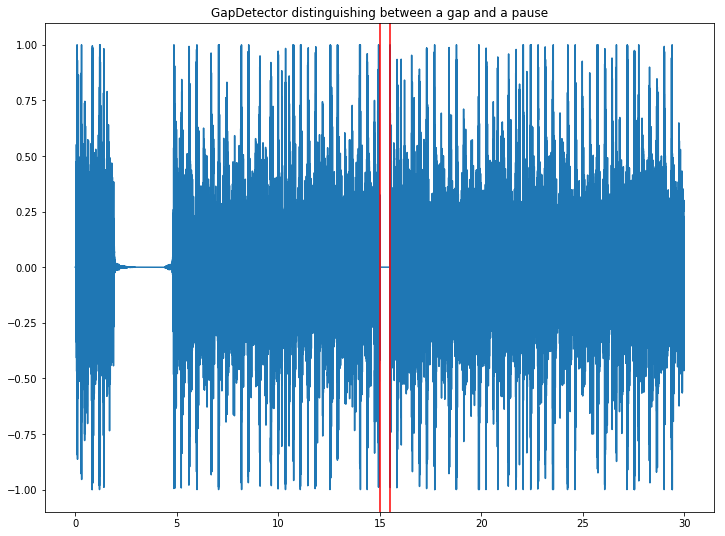

In [39]:
starts, ends = compute(audio)

plt.plot(time_axis, audio)
plt.title('GapDetector distinguishing between a gap and a pause')
for s in starts:
    plt.axvline(s, color='r')
    
for e in ends:
    plt.axvline(e, color='r')

Notice how the same pause is incorrectly detected as a gap if we reduce the pre-/post-power threshold too much:

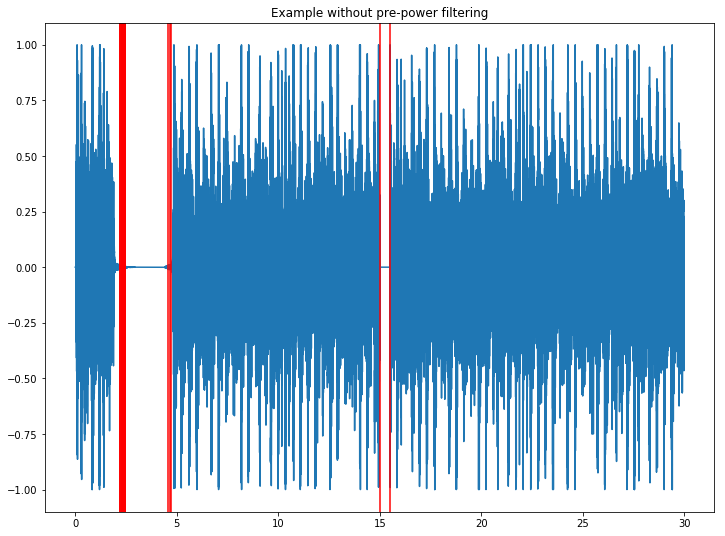

In [40]:
starts, ends = compute(audio, prepowerThreshold=-90)

times = np.linspace(0, len(audio) / sr, len(audio))

plt.plot(times, audio)
plt.title('Example without pre-power filtering')
for s in starts:
    plt.axvline(s, color='r')
    
for e in ends:
    plt.axvline(e, color='r')

## References
[1] Mühlbauer, R. (2010). Automatic Audio Defect Detection.